# Acknowledgement
This project takes input data in the form of gestures recorded using the following Android application: [GestureLogger](https://github.com/jonfroehlich/CSE590Sp2018/tree/master/A02-GestureLogger).

This project was adapted from a template Jupyter notebook written by Jon Froehlic [GestureRecognizer](https://github.com/jonfroehlich/CSE590Sp2018/tree/master/A02-GestureRecognizer)

In [1]:
# This cell includes the major classes used in our classification analyses
import matplotlib.pyplot as plt # needed for plotting
import numpy as np # numpy is primary library for numeric array (and matrix) handling
from scipy import signal 

# Each accelerometer and gyroscope log file gets parsed and made into a SensorData object
class SensorData:
    
    # Constructors in Python look like this (strangely enough)
    # All arguments are numpy arrays except sensorType, which is a str
    def __init__(self, sensorType, currentTimeMs, sensorTimestampNano, x, y, z):
        self.sensorType = sensorType
        
        # On my mac, I could cast as straight-up int but on Windows, this failed
        # This is because on Windows, a long is 32 bit but on Unix, a long is 64bit
        # So, forcing to int64 to be safe. See: https://stackoverflow.com/q/38314118
        self.currentTimeMs = currentTimeMs.astype(np.int64)
        self.sensorTimestampNano = sensorTimestampNano.astype(np.int64)
        
        self.x = x.astype(float)
        self.y = y.astype(float)
        self.z = z.astype(float)
   
        xSquared = np.multiply(self.x , self.x)
        ySquared = np.multiply(self.y, self.y)
        zSquared = np.multiply(self.z, self.z)
        self.mag = np.sqrt(np.add(xSquared, ySquared, zSquared))
        
    # Returns a dict of numpy arrays
    def get_data(self):
        return {"x":self.x, "y":self.y, "z":self.z, "mag":self.mag}
    
    # Pads the end of each data array with zeroes. Throws exception
    # if newArrayLength smaller than the current data array (and thus nothing to pad)
    def pad_with_zeros(self, newArrayLength):
        arrayLengthDiff = newArrayLength - len(self.x)
        if arrayLengthDiff < 0:
            raise ValueError("New array length '{}' must be larger than current array length '{}".
                             format(newArrayLength, len(self.x)))
        
        # np.pad allows us to pad either the left side, right side, or both sides of an array
        # in this case, we are padding only the right side. See: https://docs.scipy.org/doc/numpy/reference/generated/numpy.pad.html
        self.x = np.pad(self.x, (0, arrayLengthDiff), 'constant', constant_values=0)
        self.y = np.pad(self.y, (0, arrayLengthDiff), 'constant', constant_values=0)
        self.z = np.pad(self.z, (0, arrayLengthDiff), 'constant', constant_values=0)
        self.mag = np.pad(self.mag, (0, arrayLengthDiff), 'constant', constant_values=0)

# A trial is one gesture recording and includes an accel SensorData object and a gyro SensorData object
class Trial:
    
    # We actually parse the sensor log files in the constructor--this is probably bad practice
    # But offers a relatively clean solution
    def __init__(self, gestureName, endTimeMs, trialNum, accelLogFilenameWithPath, gyroLogFilenameWithPath):
        self.gestureName = gestureName
        self.trialNum = trialNum
        self.endTimeMs = endTimeMs
        self.accelLogFilenameWithPath = accelLogFilenameWithPath
        self.gyroLogFilenameWithPath = gyroLogFilenameWithPath
        
        # unpack=True puts each column in its own array, see https://stackoverflow.com/a/20245874
        # I had to force all types to strings because auto-type inferencing failed
        parsedAccelLogData = np.genfromtxt(accelLogFilenameWithPath, delimiter=',', 
                              dtype=str, encoding=None, skip_header=1, unpack=True)
        
        # The asterisk is really cool in Python. It allows us to "unpack" this variable
        # into arguments needed for the SensorData constructor. Google for "tuple unpacking"
        self.accel = SensorData("Accelerometer", *parsedAccelLogData[1:])
        
        parsedGyroLogData = np.genfromtxt(gyroLogFilenameWithPath, delimiter=',', 
                              dtype=str, encoding=None, skip_header=1, unpack=True)
        
        self.gyro = SensorData("Accelerometer", *parsedGyroLogData[1:])
    
    # Utility function that returns the end time as a nice string
    def getEndTimeMsAsString(self):
        return time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(self.endTimeMs / 1000))

In [2]:
# This cell contains our file handling and parsing related functions
from os import listdir
import ntpath
import os

# Returns all csv filenames in the given directory
def find_csv_filenames( path_to_dir, suffix=".csv" ):
    filenames = listdir(path_to_dir)
    return [ filename for filename in filenames if filename.endswith( suffix ) ]

# Parses and creates Trial objects for all csv files in the given dir
# Returns a dict() mapping (str: gestureName) to (list: Trial objects)
def parse_and_create_gesture_trials( path_to_dir ):
    csvFilenames = find_csv_filenames(path_to_dir)
    
    print("Found {} csv files in {}".format(len(csvFilenames), path_to_dir))
    
    mapGestureNameToTrialList = dict()
    mapGestureNameToMapEndTimeMsToMapSensorToFile = dict()
    for csvFilename in csvFilenames:
        # parse filename into meaningful parts
        filenameNoExt = os.path.splitext(csvFilename)[0];
        filenameParts = filenameNoExt.split("_")
        gestureName = filenameParts[0]
        sensorName = filenameParts[1]
        timeMs = int(filenameParts[2])
        
        # print("gestureName={} sensorName={} timeMs={}".format(gestureName, sensorName, timeMs))
        
        if gestureName not in mapGestureNameToMapEndTimeMsToMapSensorToFile:
            mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName] = dict()
        
        if timeMs not in mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName]:
            mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName][timeMs] = dict()
        
        mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName][timeMs][sensorName] = csvFilename
        # print (mapGestureNameToMapEndTimeMsToMapSensorToFile)
    
    print("Found {} gestures".format(len(mapGestureNameToMapEndTimeMsToMapSensorToFile)))
    
    # track the longest array so we can resize accordingly (by padding with zeros currently)
    maxArrayLength = -1
    trialWithMostSensorEvents = None
    
    # Now we need to loop through the data and sort each gesture set by timems values 
    # (so that we have trial 1, 2, 3, etc.)
    for gestureName, mapEndTimeMsToMapSensorToFile in mapGestureNameToMapEndTimeMsToMapSensorToFile.items():
        gestureTrialNum = 0
        mapGestureNameToTrialList[gestureName] = list()
        for endTimeMs in sorted(mapEndTimeMsToMapSensorToFile.keys()):
            mapSensorToFile = mapEndTimeMsToMapSensorToFile[endTimeMs]
            
            accelFilenameWithPath = os.path.join(logPath, mapSensorToFile["Accelerometer"])
            gyroFilenameWithPath = os.path.join(logPath, mapSensorToFile["Gyroscope"])
            
            gestureTrial = Trial(gestureName, endTimeMs, gestureTrialNum, accelFilenameWithPath, gyroFilenameWithPath)
            mapGestureNameToTrialList[gestureName].append(gestureTrial)
            
            if maxArrayLength < len(gestureTrial.accel.x):
                maxArrayLength = len(gestureTrial.accel.x)
                trialWithMostSensorEvents = gestureTrial
            
            gestureTrialNum = gestureTrialNum + 1
        
        print("Found {} trials for '{}'".format(len(mapGestureNameToTrialList[gestureName]), gestureName))
    
    # Some basic preprocessing
    # Resize arrays so everything is same length (necessary for shape matching) 
    print("Max trial length across all gesture is '{}' Trial {} with {} sensor events. Resizing all arrays to match".
          format(trialWithMostSensorEvents.gestureName, trialWithMostSensorEvents.trialNum, maxArrayLength))
    for gestureName, trialList in mapGestureNameToTrialList.items():
        for trial in trialList: 
            trial.accel.pad_with_zeros(maxArrayLength)
            trial.gyro.pad_with_zeros(maxArrayLength)
          
    return mapGestureNameToTrialList
        
# Returns the leafs in a path
# From: https://stackoverflow.com/a/8384788
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail or ntpath.basename(head)

# Utility function to extract gesture name from filename
def extract_gesture_name( filename ):
    # leaf = path_leaf(filename)
    tokenSplitPos = filename.index('_')
    gestureName = filename[:tokenSplitPos]
    return gestureName

# Returns the minimum number of trials across all gestures (just in case we accidentally recorded a 
# different number. We should have 5 or 10 each for the A2 assignment)
def get_min_num_of_trials( mapGestureToTrials ):
    minNumTrials = -1 
    for gestureName, trialSet in mapGestureToTrials.items():
        if minNumTrials == -1 or minNumTrials > len(trialSet):
            minNumTrials = len(trialSet)
    return minNumTrials

In [3]:
# Load the data

#logPath = './gestures/dan'
logPath = './gestures/jon'

mapGestureToTrials = parse_and_create_gesture_trials(logPath)

# all signals are same length
signalLength = len(list(mapGestureToTrials.values())[0][0].accel.x)
    


Found 100 csv files in ./gestures/jon
Found 10 gestures
Found 5 trials for 'At Rest'
Found 5 trials for 'Backhand Tennis'
Found 5 trials for 'Baseball Throw'
Found 5 trials for 'Forehand Tennis'
Found 5 trials for 'Midair Clockwise O'
Found 5 trials for 'Midair Counter Clockwise O'
Found 5 trials for 'Midair S'
Found 5 trials for 'Midair Zorro Z'
Found 5 trials for 'Shake'
Found 5 trials for 'Underhand Bowling'
Max trial length across all gesture is 'At Rest' Trial 3 with 323 sensor events. Resizing all arrays to match


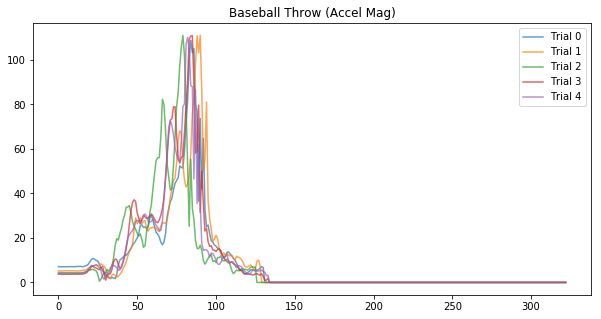

In [4]:
# Now, we need to plot and explore the data. Come up with a shape matching approach 
# and a trained model approach (e.g., decision tree, SVM) to classify the gestures

# For example, here's how you would plot one of the signals
from random import randint
gestureNamesSorted = sorted(mapGestureToTrials.keys())
randomGestureName = gestureNamesSorted[randint(0, len(gestureNamesSorted) - 1)]

# This is where we actually make the plot.
# subplots allows us to make a nice grid of plots. For example, if you want to
# make a 2,2 grid of plots, change the 1 below to 2,2
fig, axes = plt.subplots(1, figsize=(10, 5)) #figsize is width, height
gestureTrials = mapGestureToTrials[randomGestureName]
trialNum = 0
for trial in gestureTrials:
    axes.plot(trial.accel.mag, alpha=0.7, label="Trial {}".format(trialNum))
    trialNum = trialNum + 1

# set the title and show the legend
axes.set_title(randomGestureName + " (Accel Mag)")
axes.legend()


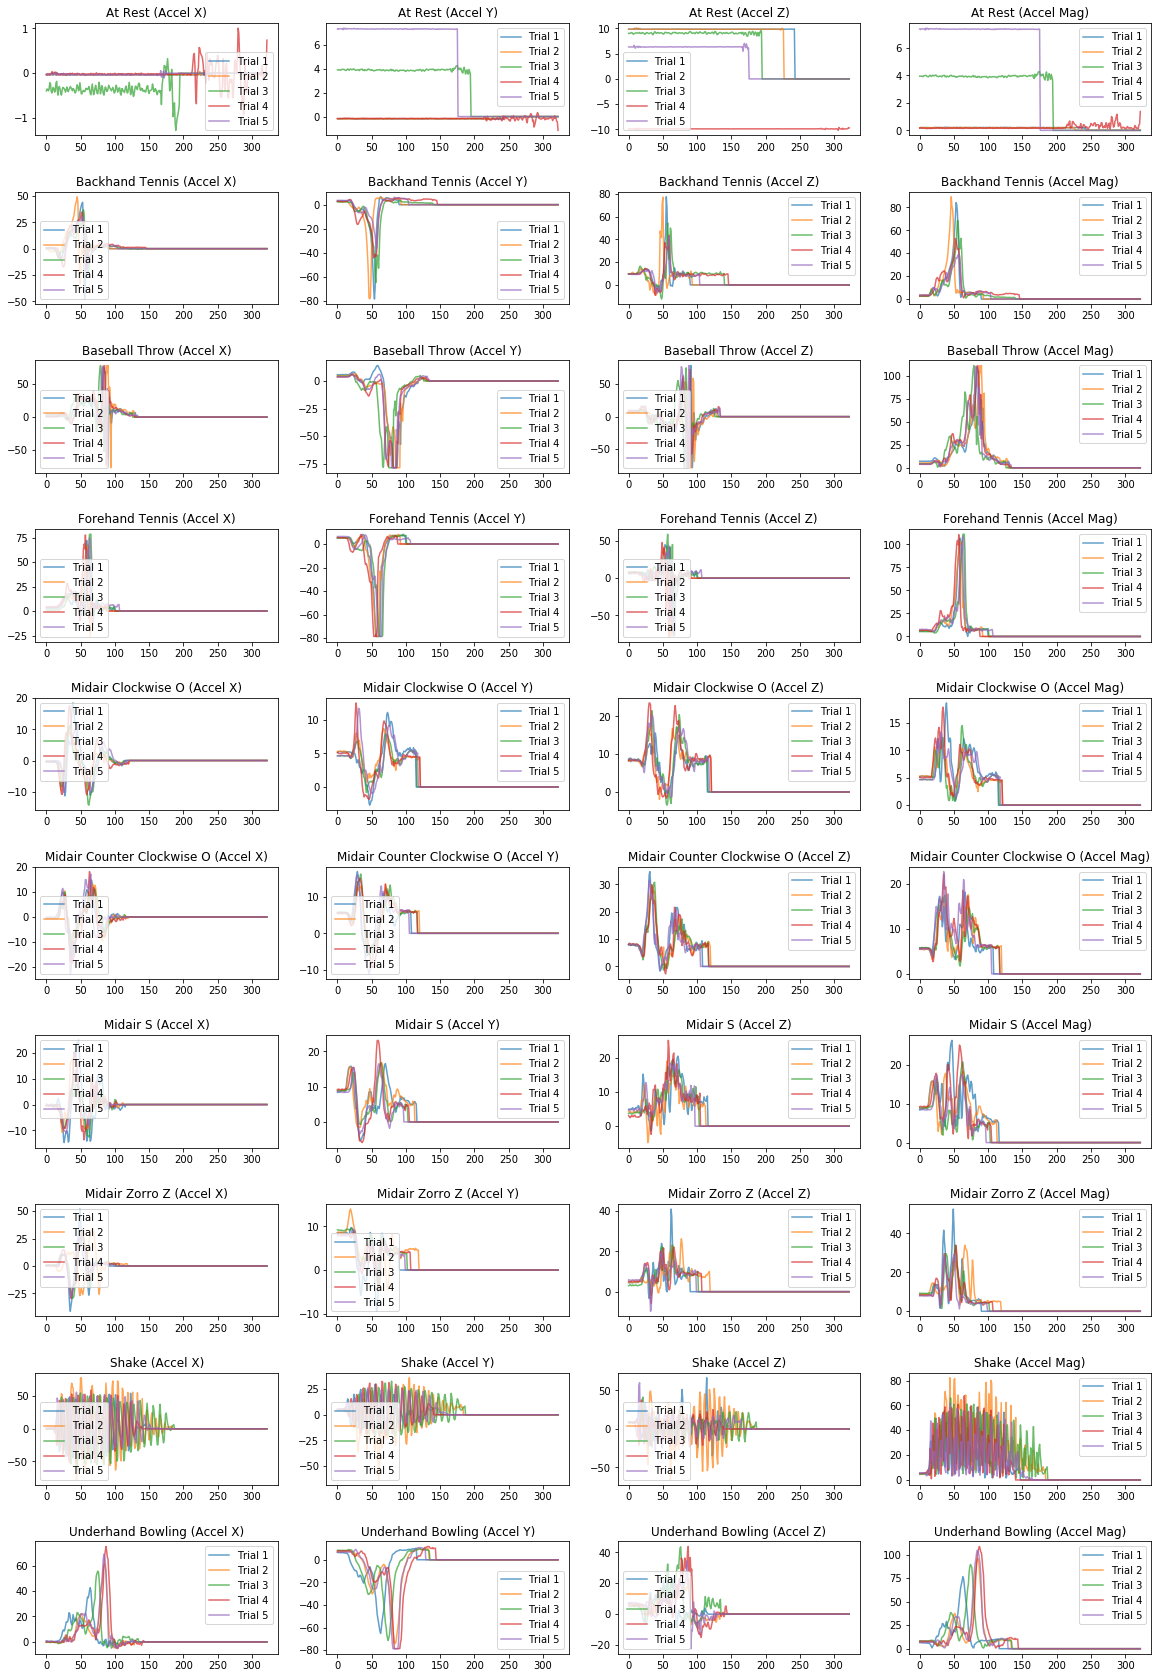

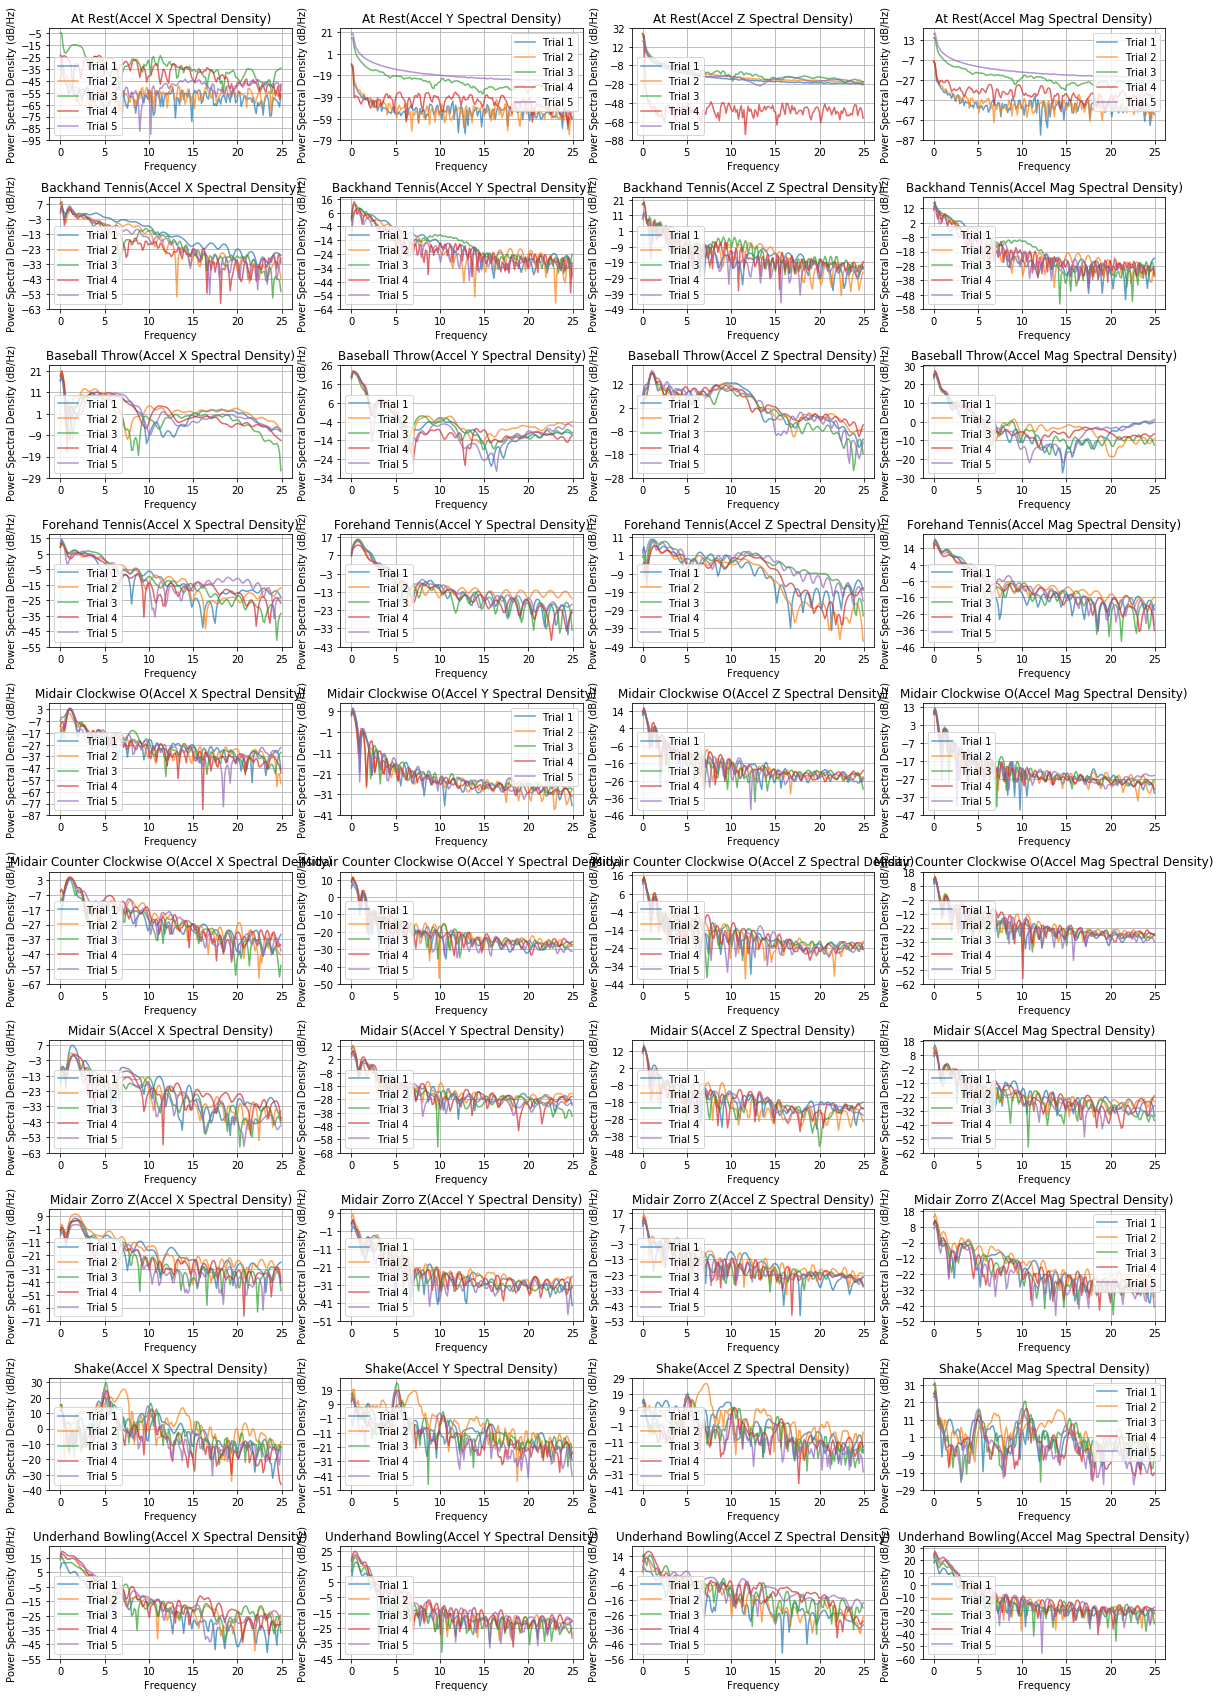

In [5]:
# Now let's plot all of the accel signals! :)

# We are going to make a grid of line graphs with a row for each gesture, so len(mapGestureToTrials) rows
# and a column for each signal type, so 4 columns (one for x, y, z, and mag)
samplingRate = 50 # Hz
fig, axes = plt.subplots(len(mapGestureToTrials), 4, figsize=(20, 3 * len(mapGestureToTrials)))
fig.subplots_adjust(hspace=0.5)

psd_fig, psd_axes = plt.subplots(len(mapGestureToTrials), 4, figsize=(20, 3 * len(mapGestureToTrials)))
psd_fig.subplots_adjust(hspace=0.5)

index = 0
gestureNamesSorted = sorted(mapGestureToTrials.keys())
for gestureName in gestureNamesSorted:
    gestureTrials = mapGestureToTrials[gestureName]
    
    trialNum = 1
    for trial in gestureTrials:
        axes[index][0].plot(trial.accel.x, alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][1].plot(trial.accel.y, alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][2].plot(trial.accel.z, alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][3].plot(trial.accel.mag, alpha=0.7, label="Trial {}".format(trialNum))
        psd_axes[index][0].psd(trial.accel.x, NFFT=signalLength, Fs=samplingRate, alpha=0.7, label="Trial {}".format(trialNum))
        psd_axes[index][1].psd(trial.accel.y, NFFT=signalLength, Fs=samplingRate, alpha=0.7, label="Trial {}".format(trialNum))
        psd_axes[index][2].psd(trial.accel.z, NFFT=signalLength, Fs=samplingRate, alpha=0.7, label="Trial {}".format(trialNum))
        psd_axes[index][3].psd(trial.accel.mag, NFFT=signalLength, Fs=samplingRate, alpha=0.7, label="Trial {}".format(trialNum))
        trialNum = trialNum + 1
        
    axes[index][0].set_title(gestureName + " (Accel X)")
    axes[index][0].legend()
    
    axes[index][1].set_title(gestureName + " (Accel Y)")
    axes[index][1].legend()
    
    axes[index][2].set_title(gestureName + " (Accel Z)")
    axes[index][2].legend()
    
    axes[index][3].set_title(gestureName + " (Accel Mag)")
    axes[index][3].legend()
    
    psd_axes[index][0].set_title(gestureName + "(Accel X Spectral Density)")
    psd_axes[index][0].legend()
    
    psd_axes[index][1].set_title(gestureName + "(Accel Y Spectral Density)")
    psd_axes[index][1].legend()
    
    psd_axes[index][2].set_title(gestureName + "(Accel Z Spectral Density)")
    psd_axes[index][2].legend()
    
    psd_axes[index][3].set_title(gestureName + "(Accel Mag Spectral Density)")
    psd_axes[index][3].legend()
    
    index = index + 1


Test Pass (True):  Baseball Throw matched Baseball Throw with distance 429.6593246060786


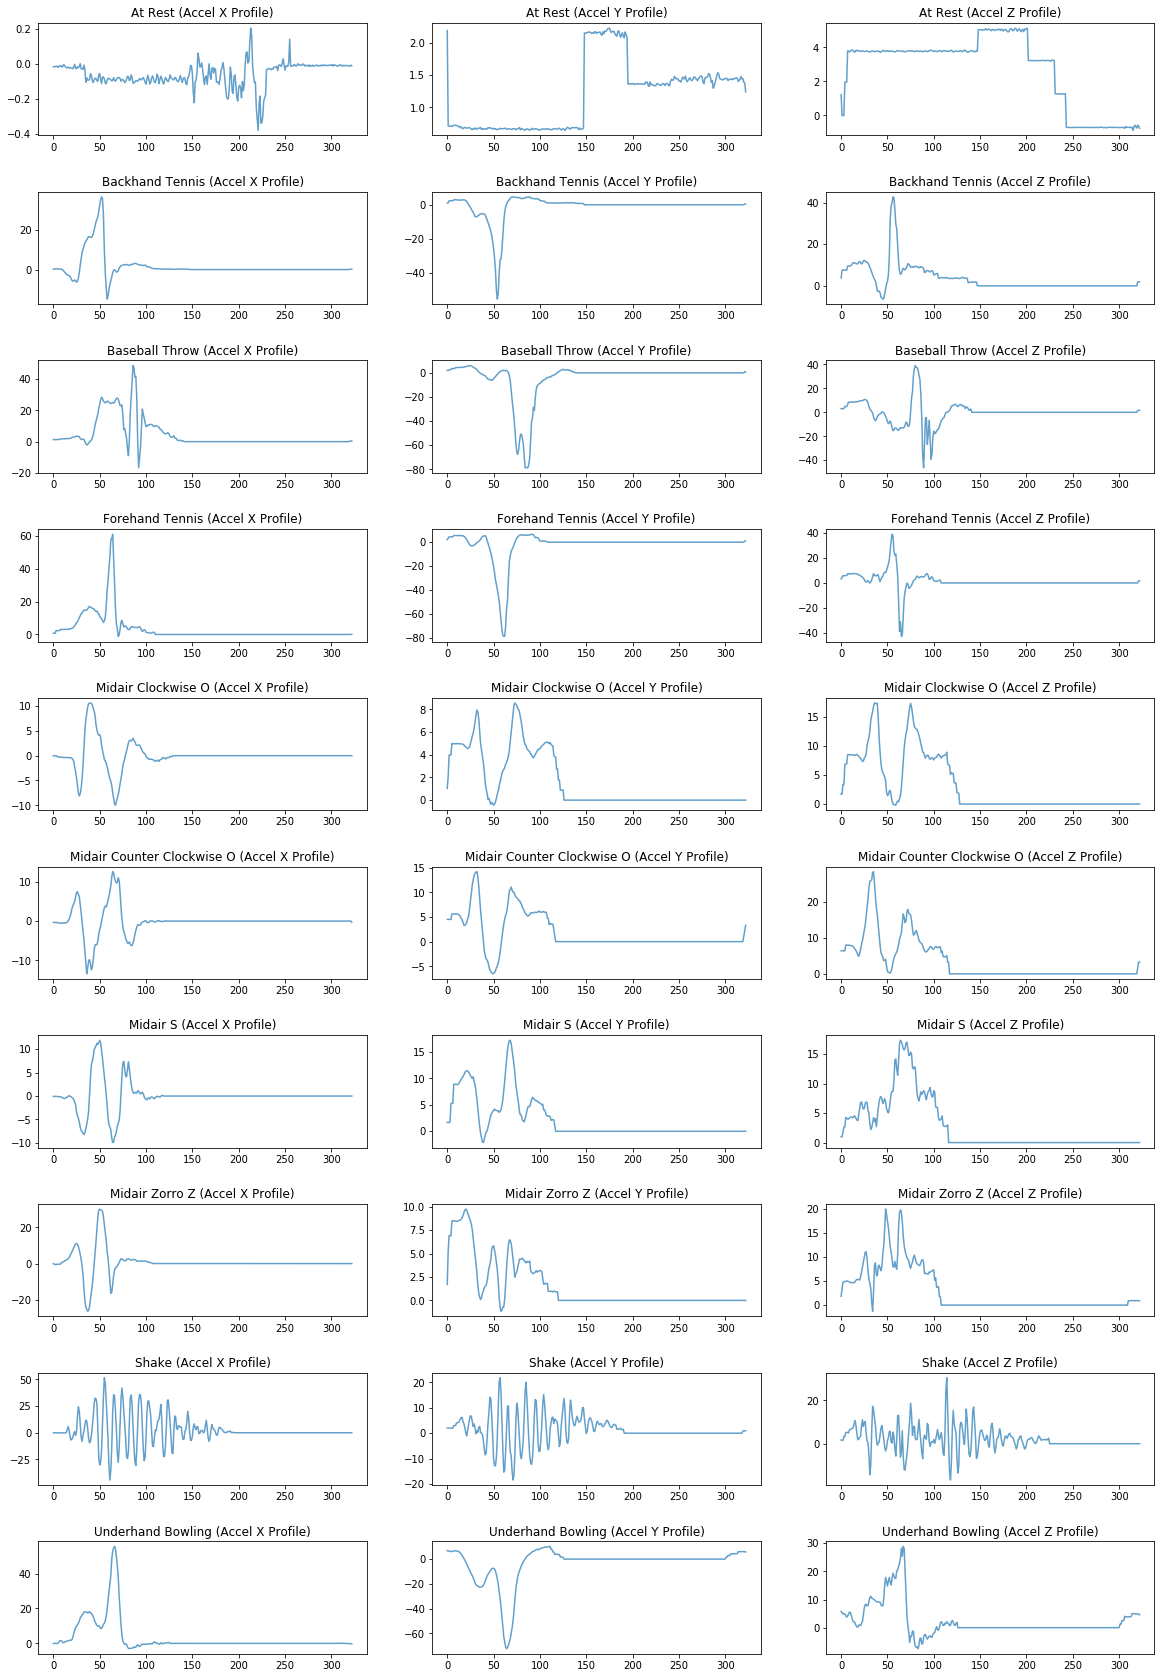

In [38]:
# In class today, I'd like you to start analyzing and comparing these gesture signals.
# Think about:
#  - What kind of filtering might be useful?
#  - What kind of signal transforms? (e.g., ffts)
#  - Is there value in exploring both the accel data AND the gyro data? 
#  - What is the simplest way we can compare two signals? (scroll down and look for distance.euclidean)?
#  - What classes might you want to create to help you keep things organized? (e.g., your k-fold experiments and results)

# 1. Sort Trials into buckets of training and test data

# 2. Shape matching
    # a. For each gesture type, generate a Gesture Profile (average gesture signal)
        # i. Align all n training inputs in each dimension
            
        # ii. Calculate mean of n inputs in each dimension
        
        # iii. Store mean of n inputs in each dimension as a "gesture profile" or a single trial
    # b. For each test trial:
        # i. For each gesture profile:
            # 1. Align test and profile for each dimension

            # 2. Calculate distance for dimension/gesture profile combination

            # 3. Lowest Euclidean average distance across all dimensions of a 
            #    given gesture profile means that test trial matches

    # c. How many test trials matched gesture profile names match their actual gesture names?

# 2.a. For each gesture types in training data, calculate the gesture profile
## 
## TODO: Update this section to only do this calculation on training buckets
##
##

def align_a_to_b( a, b ):
    correlated_a = signal.correlate(a, b)
    shift_len = len(a) - np.argmax(correlated_a)
    shifted_a = np.roll(a, shift_len)

    return shifted_a

gestureProfileMap = dict()
gestureNamesSorted = sorted(mapGestureToTrials.keys())
for gestureName in gestureNamesSorted:
    gestureTrials = mapGestureToTrials[gestureName]
    
    trials_accel_x_shifted = np.empty((len(gestureTrials), len(gestureTrials[0].accel.x)))
    trials_accel_y_shifted = np.empty((len(gestureTrials), len(gestureTrials[0].accel.y)))
    trials_accel_z_shifted = np.empty((len(gestureTrials), len(gestureTrials[0].accel.z)))
    
    # 2.a.i. Align all the signals in a dimension
    trialNum = 0

    for trial in gestureTrials:
        if(trialNum == 0):
            trials_accel_x_shifted[trialNum] = trial.accel.x
            trials_accel_y_shifted[trialNum] = trial.accel.y
            trials_accel_z_shifted[trialNum] = trial.accel.z
        else:
            # Get last of each trial dimensions
            last_accel_x = trials_accel_x_shifted[trialNum - 1]
            last_accel_y = trials_accel_y_shifted[trialNum - 1]
            last_accel_z = trials_accel_z_shifted[trialNum - 1]
            
            trials_accel_x_shifted[trialNum] = align_a_to_b(trial.accel.x, last_accel_x)
            trials_accel_y_shifted[trialNum] = align_a_to_b(trial.accel.y, last_accel_y)
            trials_accel_z_shifted[trialNum] = align_a_to_b(trial.accel.z, last_accel_z)
            
        trialNum = trialNum + 1
    
    # 2.a.ii. Calculate mean for each dimension
    gestureProfile = {
        'x': np.mean(trials_accel_x_shifted, axis=0),
        'y': np.mean(trials_accel_y_shifted, axis=0),
        'z': np.mean(trials_accel_z_shifted, axis=0)
    }
    
    # 2.a.iii. Store a single profile for the gesture
    gestureProfileMap[gestureName] = gestureProfile
            
# Graphing newly created gesture profiles
fig, axes = plt.subplots(len(gestureProfileMap), 3, figsize=(20, 3 * len(gestureProfileMap)))
fig.subplots_adjust(hspace=0.5)

index = 0
gestureProfilesSorted = sorted(gestureProfileMap.keys())
for gestureName in gestureProfilesSorted:
    gestureProfile = gestureProfileMap[gestureName]
    
    axes[index][0].plot(gestureProfile["x"], alpha=0.7)
    axes[index][0].set_title(gestureName + " (Accel X Profile)")

    axes[index][1].plot(gestureProfile["y"], alpha=0.7)
    axes[index][1].set_title(gestureName + " (Accel Y Profile)")

    axes[index][2].plot(gestureProfile["z"], alpha=0.7)
    axes[index][2].set_title(gestureName + " (Accel Z Profile)")
    
    index = index + 1

In [43]:
# 2.b. Test each trial against its corresponding gesture profiles
from scipy.spatial import distance

def test_trial_against_gesture_profiles(test_trial, gestureProfiles):
    bestDistanceMagnitude = -1
    bestDistanceProfile = ""
    
    allDistanceValues = dict()
    
    for gestureName in gestureProfiles.keys():
        gestureProfile = gestureProfiles[gestureName]
        
        # 2.b.i. Align test and profile for each dimension
        aligned_test_x = align_a_to_b(test_trial.accel.x, gestureProfile["x"])
        aligned_test_y = align_a_to_b(test_trial.accel.y, gestureProfile["y"])
        aligned_test_z = align_a_to_b(test_trial.accel.z, gestureProfile["z"])
        
        # 2.b.ii. Calculate distance for dimension/gesture profile combination
        eu_dist_x = distance.euclidean(aligned_test_x, gestureProfile["x"])
        eu_dist_y = distance.euclidean(aligned_test_y, gestureProfile["y"])
        eu_dist_z = distance.euclidean(aligned_test_z, gestureProfile["z"])
        eu_dist_total = eu_dist_x + eu_dist_y + eu_dist_z
        
        allDistanceValues[gestureName] = {
            "gesture": gestureName,
            "x": eu_dist_x,
            "y": eu_dist_y,
            "z": eu_dist_z,
            "total": eu_dist_total
        }

        # 2.b.iii. Lowest total Euclidean distance counts as match
        if (bestDistanceMagnitude == -1 or eu_dist_total < bestDistanceMagnitude):
            bestDistanceMagnitude = eu_dist_total
            bestDistanceProfile = gestureName
            
    return (testTrialName == bestDistanceProfile), bestDistanceProfile, allDistanceValues

######################################################
# TODO: Implement actual iteration through test setups
######################################################
totalTests = 0
totalPasses = 0
for i in range(30):
    testTrialName = gestureNamesSorted[randint(0, len(gestureNamesSorted) - 1)]
    testTrial = mapGestureToTrials[testTrialName][randint(0, 4)]

    testPass, bestProfile, allDistances = test_trial_against_gesture_profiles(testTrial, gestureProfileMap)
    print("Test Pass ({}):  {} matched {} with distance {}".format(testPass, testTrialName, bestProfile, allDistances[bestProfile]["total"]))

    totalTests += 1
    if testPass:
        totalPasses += 1
        
print("Total passes {} of {} tests".format(totalPasses, totalTests))




Test Pass (True):  Midair Zorro Z matched Midair Zorro Z with distance 93.97338007976462
Test Pass (True):  Midair Clockwise O matched Midair Clockwise O with distance 59.071542715682696
Test Pass (True):  Midair Counter Clockwise O matched Midair Counter Clockwise O with distance 77.55047677737467
Test Pass (True):  Shake matched Shake with distance 833.4982951322984
Test Pass (True):  Midair Counter Clockwise O matched Midair Counter Clockwise O with distance 76.02684561682157
Test Pass (True):  At Rest matched At Rest with distance 117.53332273486743
Test Pass (True):  Baseball Throw matched Baseball Throw with distance 364.3209358264852
Test Pass (True):  Midair S matched Midair S with distance 123.84924253535465
Test Pass (True):  Shake matched Shake with distance 833.4982951322984
Test Pass (True):  Midair Clockwise O matched Midair Clockwise O with distance 57.901375256720485
Test Pass (True):  At Rest matched At Rest with distance 111.5842100111123
Test Pass (True):  Midair Zor

# Sandbox
Everything below here is a Sandbox for you to play. You could do this in another Jupyter Notebook but I often have some cells at the bottom of my notebook that let's me experiment with and play with Python and the numpy, scipy, etc. libraries. I've added some example playground cells that I used when making the assignment.

Feel free to delete all of these cells but I thought they might be informative for you.

In [7]:
# Testing to see if the numpy 'where' method supports string matching
a = np.array(['apple', 'orange', 'apple', 'banana'])

indicesWhereThereAreApples = np.where(a == 'apple')

print (indicesWhereThereAreApples)
print (a[indicesWhereThereAreApples])

(array([0, 2], dtype=int64),)
['apple' 'apple']


In [8]:
# Playing around with classes in Python 3. Notice how just like in Javascript, you can add a new member variable
# just by starting to use it!

class DummyClass:
    def __init__(self, variable):
        self.testVar = variable
        

dummy = DummyClass(5)
print(dummy.testVar)
dummy.newVar = 7 # added a new member variable called newVar here. Cool!
print(dummy.newVar)
vars(dummy) # prints out the member variables of the class

5
7


{'newVar': 7, 'testVar': 5}

In [9]:
# Experimenting with how folding and unfolding tuples work
testTuple = (1,2,3,4,5,6,7,8,9,10)
print(testTuple)
print(*testTuple)
print(*testTuple[5:])

(1, 2, 3, 4, 5, 6, 7, 8, 9, 10)
1 2 3 4 5 6 7 8 9 10
6 7 8 9 10


In [10]:
# Experimenting with how we delete things out of lists
import random
testDict = {"a":1, "c":3, "d":4}
a = list(testDict.keys())
print(a)
random.shuffle(a)
print(a)
del a[1]
print(a)

['a', 'c', 'd']
['c', 'a', 'd']
['c', 'd']


In [11]:
# Playing around with how we can split up and combine lists in Python
testList = [1, 2, 3, 4, 5]
index = 4
print(testList[0:index] + testList[index + 1:5])

index = 3
print(testList[0:index] + testList[index + 1:5])

print(testList[index:])
print(testList[:index])

[1, 2, 3, 4]
[1, 2, 3, 5]
[4, 5]
[1, 2, 3]


In [12]:
# playing around with numpy subtraction. In order for these operations to work
# the arrays must be of the same size
np1 = np.array([1, 2, 3, 4, 5])
np2 = np.array([1, 2, 4, 5, 5])
np2 - np1

np3 = [1, 2, 3]

# the (0,2) value tells pad to pad 0 times in the front of array
# and three times to the end of array. See: https://docs.scipy.org/doc/numpy/reference/generated/numpy.pad.html
np3_resized = np.pad(np3, (0, 2), 'constant', constant_values=0)
np3_resized - np2

array([ 0,  0, -1, -5, -5])

In [13]:
# Find Euclidean distance between two numpy vector arrays
np1 = np.array([1, 2, 3, 4, 5])
np2 = np.array([5, 4, 3, 2, 1])

# First, we'll try numpy's way of determining Euclidean distance
# See: https://stackoverflow.com/a/1401828
npDist = np.linalg.norm(np2 - np1)
print(npDist)

# Next, we'll try scipy's way
# See: https://stackoverflow.com/a/21986532
from scipy.spatial import distance

scipyDist = distance.euclidean(np2,np1)
print(scipyDist)

6.324555320336759
6.324555320336759


[ 6.70082798 34.11252326 31.82126843 41.03955674  2.40857267 12.13347461
 29.36119716 36.32545308  9.02054481 26.10431717 43.77253311 33.97780341
 15.9765258   4.09805788 39.16206149 42.36284845  6.68132723 15.63692983
 14.24107182 24.76890693 39.14608607 35.59140874 21.24659936 23.58307559
 36.87869072 25.06183095 28.11629926  8.0457114   9.76627097 43.77649043
 27.18464893  9.48738167 10.68205541 26.0318458  22.63904505 33.01916164
 34.15413965 24.53469706 18.21227553 21.78743869 41.69738108 28.44156377
 10.71291088 14.35158924 19.12133419 49.35614674 10.5736564  18.8293068
 45.64419602 13.93125548]


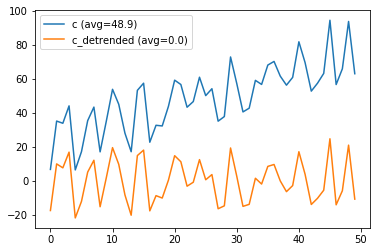

In [14]:
# detrend playground
from scipy import signal
a = np.random.rand(50) * 50
print(a)
b = np.array(range(0,50))
c = a + b

fig, axes = plt.subplots()
# axes.plot(a)
# axes.plot(b)
axes.plot(c, label="c (avg={:0.1f})".format(np.mean(c)))
c_detrended = signal.detrend(c)
axes.plot(c_detrended, label="c_detrended (avg={:0.1f})".format(np.mean(c_detrended)))
axes.legend()


Confusion matrix, without normalization
[[2 0 0]
 [0 1 1]
 [1 0 2]]
Normalized confusion matrix
[[1.         0.         0.        ]
 [0.         0.5        0.5       ]
 [0.33333333 0.         0.66666667]]


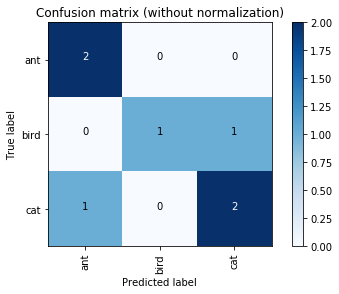

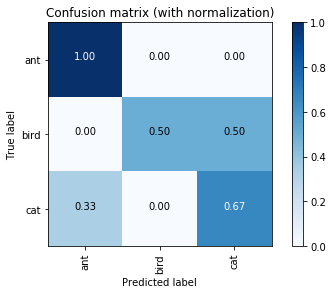

In [15]:
# Playing around with plotting confusion matrices
# From: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
y_true = ["cat", "ant", "cat", "cat", "ant", "bird", "bird"]
y_pred = ["ant", "ant", "cat", "cat", "ant", "cat", "bird"]
labels=["ant", "bird", "cat"]
cm = confusion_matrix(y_true, y_pred, labels)
plt.figure()
plot_confusion_matrix(cm, classes=labels,
                      title='Confusion matrix (without normalization)')

plt.figure()
plot_confusion_matrix(cm, classes=labels, normalize=True,
                      title='Confusion matrix (with normalization)')
plt.show()

In [16]:
from scipy.signal import butter, lfilter

# Testing Butterworth filtering, outcome is that it seems human movement is well-filtered by our Nyquist frequency
nyquistFreq = samplingRate / 2.0
desiredCutOffFreq = 20 # Hz, based on Mladenov
desiredCutOffFreqNormalized = desiredCutOffFreq / nyquistFreq

# Ideally, with an infinite "filter order", you would get a perfect filter
# that cuts off all frequencies within your desired band. In practice, you
# are dealing with finite data and so a super high filter order will distort your signal
# Generally, filter orders can be relatively small (on the order of 10s or less like 6 or 9) but play around!
# http://scipy.github.io/old-wiki/pages/Cookbook/ButterworthBandpass
filterOrder = 30
b, a = butter(filterOrder, desiredCutOffFreqNormalized, btype='lowpass')

# Use lfilter to apply the filter: https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.signal.lfilter.html

fig, axes = plt.subplots(len(mapGestureToTrials), 4, figsize=(20, 3 * len(mapGestureToTrials)))
fig.subplots_adjust(hspace=0.5)

psd_fig, psd_axes = plt.subplots(len(mapGestureToTrials), 4, figsize=(20, 3 * len(mapGestureToTrials)))
psd_fig.subplots_adjust(hspace=0.5)

index = 0
gestureNamesSorted = sorted(mapGestureToTrials.keys())
for gestureName in gestureNamesSorted:
    gestureTrials = mapGestureToTrials[gestureName]

    trialNum = 1
    for trial in gestureTrials:
        axes[index][0].plot(lfilter(b, a, trial.accel.x), alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][1].plot(lfilter(b, a, trial.accel.y), alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][2].plot(lfilter(b, a, trial.accel.z), alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][3].plot(lfilter(b, a, trial.accel.mag), alpha=0.7, label="Trial {}".format(trialNum))
        psd_axes[index][0].psd(lfilter(b, a, trial.accel.x), NFFT=signalLength, Fs=samplingRate, alpha=0.7, label="Trial {}".format(trialNum))
        psd_axes[index][1].psd(lfilter(b, a, trial.accel.y), NFFT=signalLength, Fs=samplingRate, alpha=0.7, label="Trial {}".format(trialNum))
        psd_axes[index][2].psd(lfilter(b, a, trial.accel.z), NFFT=signalLength, Fs=samplingRate, alpha=0.7, label="Trial {}".format(trialNum))
        psd_axes[index][3].psd(lfilter(b, a, trial.accel.mag), NFFT=signalLength, Fs=samplingRate, alpha=0.7, label="Trial {}".format(trialNum))

        trialNum = trialNum + 1

    axes[index][0].set_title(gestureName + " (Accel X Smoothed)")
    axes[index][0].legend()

    axes[index][1].set_title(gestureName + " (Accel Y Smoothed)")
    axes[index][1].legend()

    axes[index][2].set_title(gestureName + " (Accel Z Smoothed)")
    axes[index][2].legend()

    axes[index][3].set_title(gestureName + " (Accel Mag Smoothed)")
    axes[index][3].legend()
    
    psd_axes[index][0].set_title(gestureName + "(Accel X Spectral Density)")
    psd_axes[index][0].legend()
    
    psd_axes[index][1].set_title(gestureName + "(Accel Y Spectral Density)")
    psd_axes[index][1].legend()
    
    psd_axes[index][2].set_title(gestureName + "(Accel Z Spectral Density)")
    psd_axes[index][2].legend()
    
    psd_axes[index][3].set_title(gestureName + "(Accel Mag Spectral Density)")
    psd_axes[index][3].legend()
    
    index = index + 1

NameError: name 'butter' is not defined